In [1]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from numba import jit, cuda 

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

In [15]:
sections = pd.read_csv("sections.csv")
sections.head()

,section_num,section,book_title,book_num
0,1,I\n\nOm! Having bowed down to Narayana and Na...,ADI PARVA,1
1,2,"II\n\n""The Rishis said, 'O son of Suta, we wi...",ADI PARVA,1
2,3,"III\n\n(Paushya Parva)\n\nSauti said, ""Janame...",ADI PARVA,1
3,4,"IV\n\n(Pauloma Parva)\n\n'UGRASRAVA SAUTI, th...",ADI PARVA,1
4,5,"V\n\n(Pauloma Parva continued)\n\n""Saunaka sa...",ADI PARVA,1


In [16]:
sections['section'] = sections.section.str.replace("\n", " ")

In [36]:
sections.head(1356)

,section_num,section,book_title,book_num
0,1,I Om! Having bowed down to Narayana and Nara...,ADI PARVA,1
1,2,"II ""The Rishis said, 'O son of Suta, we wish...",ADI PARVA,1
2,3,"III (Paushya Parva) Sauti said, ""Janamejaya...",ADI PARVA,1
3,4,"IV (Pauloma Parva) 'UGRASRAVA SAUTI, the so...",ADI PARVA,1
4,5,"V (Pauloma Parva continued) ""Saunaka said, ...",ADI PARVA,1
...,...,...,...,...
1351,32,"32 (Gada-yuddha Parva) ""Dhritarashtra said,...",SHALYA-PARVA,9
1352,33,"33 ""Sanjaya said, 'Whilst Duryodhana, O king...",SHALYA-PARVA,9
1353,34,"34 ""Sanjaya said, 'When that fierce battle, ...",SHALYA-PARVA,9
1354,35,"35 Janamejaya said, ""On the eve of the great...",SHALYA-PARVA,9


In [94]:
chaptersDict = {}
bookTitles = []
for i in range(len(sections)):
    bookTitles.append(sections.loc[i]['book_title'])
bookTitles = list(set(bookTitles))
bookTitles

['ADI PARVA',
 'SHALYA-PARVA',
 'VANA PARVA',
 'SANTI PARVA',
 'DRONA PARVA',
 'MAUSALA-PARVA',
 'UDYOGA PARVA',
 'BHISHMA PARVA',
 'VIRATA PARVA',
 'SVARGAROHANIKA-PARVA',
 'ASRAMAVASIKA PARVA',
 'ASWAMEDHA PARVA',
 'SAUPTIKA-PARVA',
 'KARNA-PARVA',
 'STRI-PARVA',
 'MAHAPRASTHANIKA PARVA',
 'SABHA PARVA',
 'ANUSASANA PARVA']

In [116]:
for i in range(len(bookTitles)):
    bookContent = ""
    for j in range(len(sections)):
        if(sections.loc[j]['book_title'] is bookTitles[i]):
            bookContent+=sections.loc[j]['section']
    chaptersDict[bookTitles[i]] = bookContent

In [117]:
chaptersDict["ADI PARVA"]

' I  Om! Having bowed down to Narayana and Nara, the most exalted male being, and also to the goddess Saraswati, must the word Jaya be uttered.  Ugrasrava, the son of Lomaharshana, surnamed Sauti, well-versed in the Puranas, bending with humility, one day approached the great sages of rigid vows, sitting at their ease, who had attended the twelve years\' sacrifice of Saunaka, surnamed Kulapati, in the forest of Naimisha. Those ascetics, wishing to hear his wonderful narrations, presently began to address him who had thus arrived at that recluse abode of the inhabitants of the forest of Naimisha. Having been entertained with due respect by those holy men, he saluted those Munis (sages) with joined palms, even all of them, and inquired about the progress of their asceticism. Then all the ascetics being again seated, the son of Lomaharshana humbly occupied the seat that was assigned to him. Seeing that he was comfortably seated, and recovered from fatigue, one of the Rishis beginning the 

In [118]:
analyzer = SentimentIntensityAnalyzer()

In [120]:
sentimentsDictionary = {}
for book_name,content in tqdm(chaptersDict.items(),desc='Progress'):
    sentence_list = tokenize.sent_tokenize(content)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    
    for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    sentimentsDictionary[book_name] = sentiments

In [123]:
sentimentsDictionary

{'ADI PARVA': {'compound': 0.17500560633759898,
  'neg': 0.058813615391311996,
  'neu': 0.8173271524331863,
  'pos': 0.12385757813180101},
 'SHALYA-PARVA': {'compound': 0.08853879591393196,
  'neg': 0.0891734405564012,
  'neu': 0.7934272984133899,
  'pos': 0.11739882634209955},
 'VANA PARVA': {'compound': 0.16283574481458118,
  'neg': 0.06282847265870534,
  'neu': 0.8159666247643007,
  'pos': 0.12120282840980501},
 'SANTI PARVA': {'compound': 0.1209321882869507,
  'neg': 0.059653806418286215,
  'neu': 0.8342610576612656,
  'pos': 0.10608394137018194},
 'DRONA PARVA': {'compound': 0.022206566358655998,
  'neg': 0.0942502248752967,
  'neu': 0.806303295445252,
  'pos': 0.0994481969089868},
 'MAUSALA-PARVA': {'compound': 0.015720772946859918,
  'neg': 0.08446376811594199,
  'neu': 0.8323671497584539,
  'pos': 0.0831497584541063},
 'UDYOGA PARVA': {'compound': 0.1338787984278482,
  'neg': 0.07588467153284659,
  'neu': 0.7986984839977525,
  'pos': 0.12541706906232378},
 'BHISHMA PARVA': {'co

In [125]:
compound_sentiments = [sentimentsDictionary[i]['compound'] for i in bookTitles]
print(compound_sentiments)

[0.17500560633759898, 0.08853879591393196, 0.16283574481458118, 0.1209321882869507, 0.022206566358655998, 0.015720772946859918, 0.1338787984278482, 0.05333053207951457, 0.11241964819117191, 0.17759204301075257, 0.14218315621679084, 0.14254931374444235, -0.005912286995515688, 0.03421357964673487, -0.02939928952042625, 0.18117712765957442, 0.19925883668903888, 0.18382576814326082]


In [126]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Text(0, 0.5, 'Average Sentiment')

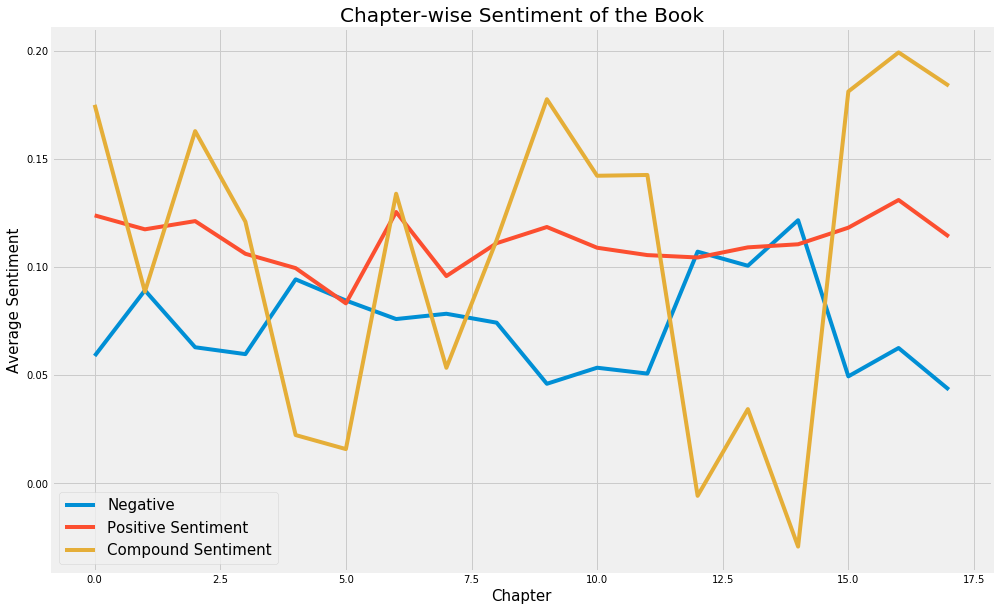

In [209]:
length = len(bookTitles)
neg_sentiment = []
neu_sentiment = []
pos_sentiment = []
compound_sentiment = []

x = np.linspace(0, length - 1, num=length)
for k,v in sentimentsDictionary.items():
    neg_sentiment.append(v['neg'])
    neu_sentiment.append(v['neu'])
    pos_sentiment.append(v['pos'])
    compound_sentiment.append(v['compound'])
plt.figure(figsize=(15, 10))
plt.plot(x,neg_sentiment,label = "Negative")
# plt.plot(x,neu_sentiment,label = "Neutral Sentiment")
plt.plot(x,pos_sentiment,label = "Positive Sentiment")
plt.plot(x,compound_sentiment,label = "Compound Sentiment")
plt.legend(loc='best', fontsize=15)
plt.title('Chapter-wise Sentiment of the Book', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)

In [210]:
words_csv = pd.read_csv("words.csv")
words_csv.head()

,Unnamed: 0,word_num,word,sentence_num,section_num,book_title,book_num,lemma,POS,stop
0,0,1,I,1,1,ADI PARVA,1,-PRON-,PRON,True
1,1,1,Om,2,1,ADI PARVA,1,Om,PROPN,False
2,2,2,!,2,1,ADI PARVA,1,!,PUNCT,False
3,3,1,Having,3,1,ADI PARVA,1,have,VERB,False
4,4,2,bowed,3,1,ADI PARVA,1,bow,VERB,False


In [217]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [221]:
def text_emotion(df,column):
    new_df = df.copy()
    filepath = 'NRC_emotion_lexicon_list.txt'
    
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")  
    
#     print("Emolex_df\n",emolex_df.head())
#     print("Emolex_words:",emolex_words)
#     print("Emotions:",emotions)
#     print("emo_df.head():",emo_df.head())
    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [222]:
data = {'book_name': [], 'text': []}
for book_name,book in chaptersDict.items():

    data['book_name'].append(book_name)
    data['text'].append(book)
    
chap_df = pd.DataFrame(data=data)
print(chap_df)

                book_name                                               text
0               ADI PARVA   I  Om! Having bowed down to Narayana and Nara...
1            SHALYA-PARVA   1  Om! Having bowed down unto Narayana and Na...
2              VANA PARVA   I  (Aranyaka Parva)  Om! Having bowed down to...
3             SANTI PARVA   I  (Rajadharmanusasana Parva)  OM! HAVING BOW...
4             DRONA PARVA   I  (Dronabhisheka Parva)  OM! HAVING BOWED do...
5           MAUSALA-PARVA   1  Om! Having bowed down unto Narayana, and t...
6            UDYOGA PARVA   I  OM! HAVING BOWED down to Narayana, and Nar...
7           BHISHMA PARVA   I  (Jamvu-khanda Nirmana Parva)  OM! HAVING B...
8            VIRATA PARVA   I  (Pandava-Pravesa Parva)  OM! Having bowed ...
9    SVARGAROHANIKA-PARVA   1  Om! Having bowed down into Narayana, and t...
10     ASRAMAVASIKA PARVA   I  (Asramavasa Parva)  OM! AFTER HAVING bowed...
11        ASWAMEDHA PARVA   I  (Aswamedhika Parva)  OM! HAVING BOWED down...

# DO NOT TOUCH THE CELL BELOW

In [223]:
chap_df = text_emotion(chap_df, 'text')

# DO NOT TOUCH THE CELL ABOVE

In [224]:
chap_df.to_csv('chap_with_emo_scores.csv')

In [225]:
chap_df.head()

,book_name,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,ADI PARVA,I Om! Having bowed down to Narayana and Nara...,3039,6147,2064,4846,6609,6092,13072,3225,2863,7908
1,SHALYA-PARVA,1 Om! Having bowed down unto Narayana and Na...,1837,2193,751,2550,2201,3145,5008,1395,1111,2945
2,VANA PARVA,I (Aranyaka Parva) Om! Having bowed down to...,4629,8870,3264,7322,8995,9356,19686,4816,4042,12052
3,SANTI PARVA,I (Rajadharmanusasana Parva) OM! HAVING BOW...,6619,14791,4776,11187,15165,15001,31240,8755,6658,19500
4,DRONA PARVA,I (Dronabhisheka Parva) OM! HAVING BOWED do...,6185,5187,1987,7365,4937,9144,11736,3934,3785,6236


In [226]:
chap_df['word_count'] = chap_df['text'].apply(tokenize.word_tokenize).apply(len)
chap_df.head()

,book_name,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,ADI PARVA,I Om! Having bowed down to Narayana and Nara...,3039,6147,2064,4846,6609,6092,13072,3225,2863,7908,271572
1,SHALYA-PARVA,1 Om! Having bowed down unto Narayana and Na...,1837,2193,751,2550,2201,3145,5008,1395,1111,2945,109113
2,VANA PARVA,I (Aranyaka Parva) Om! Having bowed down to...,4629,8870,3264,7322,8995,9356,19686,4816,4042,12052,386140
3,SANTI PARVA,I (Rajadharmanusasana Parva) OM! HAVING BOW...,6619,14791,4776,11187,15165,15001,31240,8755,6658,19500,635859
4,DRONA PARVA,I (Dronabhisheka Parva) OM! HAVING BOWED do...,6185,5187,1987,7365,4937,9144,11736,3934,3785,6236,302861


In [227]:
emotions = ['anger', 'anticipation','disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise','trust']

In [228]:
for emotion in emotions:
    chap_df[emotion] = chap_df[emotion] / chap_df['word_count']

In [235]:
chap_df.head()

,book_name,text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,ADI PARVA,I Om! Having bowed down to Narayana and Nara...,0.011190,0.022635,0.007600,0.017844,0.024336,0.022432,0.048135,0.011875,0.010542,0.029119,271572
1,SHALYA-PARVA,1 Om! Having bowed down unto Narayana and Na...,0.016836,0.020098,0.006883,0.023370,0.020172,0.028823,0.045897,0.012785,0.010182,0.026990,109113
2,VANA PARVA,I (Aranyaka Parva) Om! Having bowed down to...,0.011988,0.022971,0.008453,0.018962,0.023295,0.024230,0.050982,0.012472,0.010468,0.031211,386140
3,SANTI PARVA,I (Rajadharmanusasana Parva) OM! HAVING BOW...,0.010410,0.023261,0.007511,0.017594,0.023850,0.023592,0.049130,0.013769,0.010471,0.030667,635859
4,DRONA PARVA,I (Dronabhisheka Parva) OM! HAVING BOWED do...,0.020422,0.017127,0.006561,0.024318,0.016301,0.030192,0.038750,0.012989,0.012497,0.020590,302861


In [ ]:
chap_df.to_csv("chap_with_emo_scores_no.csv")

In [230]:
import seaborn as sns
sns.set_palette(sns.color_palette("Paired", 20))

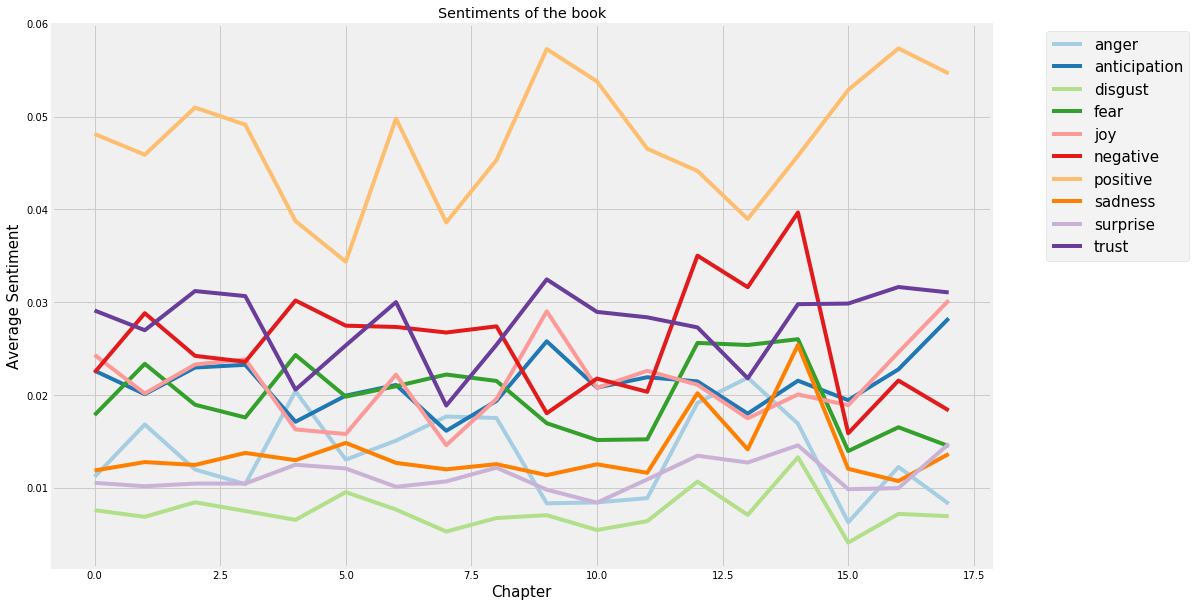

In [234]:
length = len(bookTitles)
x = np.linspace(0, length - 1, num=length)
fig= plt.figure(figsize=(15,10))

for i in range(len(emotions)):
    emo = (emotions[i])
    y = [i for i in chap_df[emo]]
    plt.plot(x,y,label = emo)

plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
plt.title('Sentiments of the book')
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()